** *
# Microsoft Malware Classification Challenge (BIG 2015)

---


https://www.kaggle.com/c/malware-classification/


>[Microsoft Malware Classification Challenge (BIG 2015)](#scrollTo=zMYQUkNl3e3I)

>[Initial Setup](#scrollTo=U0PO6PE-0JFr)

>>[Download Dataset](#scrollTo=afqc3ABYzOTC)

>[Extract Features](#scrollTo=ms9rLqS_pgRl)

>>[Split train and valid set](#scrollTo=xBoVaLxnqveu)

>>[Saving processed data](#scrollTo=_7pE87gkp-yb)

>[N-grams](#scrollTo=qYMaw8Q0kFjx)



# Initial Setup

## Download Dataset

In [1]:
!pip install kaggle

    100% |████████████████████████████████| 51kB 3.7MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/61/d6/e6/38fc0e2316f49b91aafdaf9a8d7756a9906b2ad7e501c1e165
Successfully built kaggle


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

if not os.path.exists('data/'):

    auth.authenticate_user()

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/content/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)

    !kaggle competitions download -c malware-classification -p data/
    
else:
    print('Dataset already downloaded!')

Dataset already downloaded!


In [0]:
import re
import glob
from tqdm import tqdm
#from tqdm import tqdm_notebook


import numpy as np
import pandas as pd

import multiprocessing
from multiprocessing.dummy import Pool

In [0]:
seed=42
np.random.seed(seed)

In [6]:
cpu_count  = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 3


In [8]:
!cd data && p7zip -d train.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      0% - train/01azqd4InC7m9JpocGv5.asm                                       0% 1 - train/01IsoiSMh5gxyDYTl4CB.asm                                         0% 2 - train/01jsnpXSAlgw6aPeDxrU.asm                                         0% 6 - train/02JqQ7H3yEoD8viYWlmS.asm

                                          0% 57 - train/0bjN3Kgw5OATSreRmEdi.asm                                          0% 59 - train/0BLbmzJRkjNynCgQIdtV.asm                                          0% 60 - train/0bN6ODYWw2xeCQBn3tEg.asm                                          0% 62 - train/0BZQIJak6Pu2tyAXfrzR.asm                                          0% 65 - train/0cfGJLYgE6ROaZH7KT1h.asm                                          0% 67 - train/0cGWK6VvCkm7O2AxDjtw.asm

                                           1% 117 - train/0gL3h5G6CszBV7RSinjJ.asm                                           1% 120 - train/0Gu4misTcKynQD2Ol1Jx.asm                                           1% 122 - train/0gUpzkLVT73PCXx5WFRI.asm                                           1% 123          1% 123 - train/0GuYe4J7oLwQ82xr3pWS.asm                                           1% 124 - train/0GVcTdBQXWUJ2t7vjphN.asm^C
                                         
Archives with Errors:

# Extract Features

In [0]:
def getOpcodes(file2path):

    openfile = io.open(file2path,'r',encoding='latin-1')
    lines=openfile.readlines()

    opcodes_lst = []

    for line in lines:
        opcode_group = re.search('\s\s\s[a-z][a-z]+\s\s\s',line)
        if opcode_group:
            opcode = opcode_group.group().strip()
            opcodes_lst.append(opcode)
            pass
            
    return opcodes_lst, file2path

In [0]:
def extractInParallel(path_lst, threads=2):
    p = Pool(threads)
    opcodes_lst = []
    file_lst = []
    for opcode, file in tqdm((p.imap_unordered(getOpcodes, path_lst)), total=len(path_lst)):
        opcodes_lst.append(opcode)
        file_lst.append(file)
        pass
    p.close()
    p.join()
    return opcodes_lst, file_lst

In [0]:
def process_targets(trainLabels, y):
  
    target_lst = []
    for file in y:
        f = file.split('/')[-1][:-4]
        target_lst.append(int(trainLabels[trainLabels['Id'] == f]['Class']))
          
    return target_lst

In [0]:
def extractFeatures(path2data, trainLabels, format_file = '*.asm'):
  
    for subdir, dirs, files in os.walk(path2data):
          print('Reading files from dir: {}'.format(subdir))
          path_folder = os.path.join(subdir, format_file)
          filesPath = glob.glob(path_folder) 
          print('Extractig features from: {} files'.format(len(filesPath)))
          opcodes_lst, file_lst =  extractInParallel(filesPath, threads=cpu_count)
          
          y = process_targets(trainLabels, file_lst)
          print('\nDone!')

    return np.array(opcodes_lst), np.array(y)

In [0]:
trainLabels = pd.read_csv('data/trainLabels.csv')

In [63]:
trainLabels.head()

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1


In [41]:
path2train = 'data/train'
X, y = extractFeatures(path2train, trainLabels)

  0%|          | 0/127 [00:00<?, ?it/s]

Reading files from dir: data/train
Extractig features from: 127 files


100%|██████████| 127/127 [01:58<00:00,  1.07it/s]



Done!


In [59]:
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (127,)
y shape: (127,)


###  Dataset Analysis

In [0]:
df_X = pd.DataFrame(list(X))
df_y = pd.DataFrame(list(y), columns=['targets'])

In [61]:
df_X.head()

,0,1,2,3,4,5,6,7,8,9,...,811186,811187,811188,811189,811190,811191,811192,811193,811194,811195
0,mov,push,mov,sub,mov,and,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None
1,mov,push,mov,sub,mov,xor,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None
2,mov,push,push,push,push,call,pop,lea,push,call,...,None,None,None,None,None,None,None,None,None,None
3,mov,push,mov,sub,lea,sbb,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None
4,mov,push,mov,sub,lea,xor,push,push,push,push,...,None,None,None,None,None,None,None,None,None,None


In [0]:
import matplotlib.pyplot as plt

Text(0.5,0,'#ocorrences')

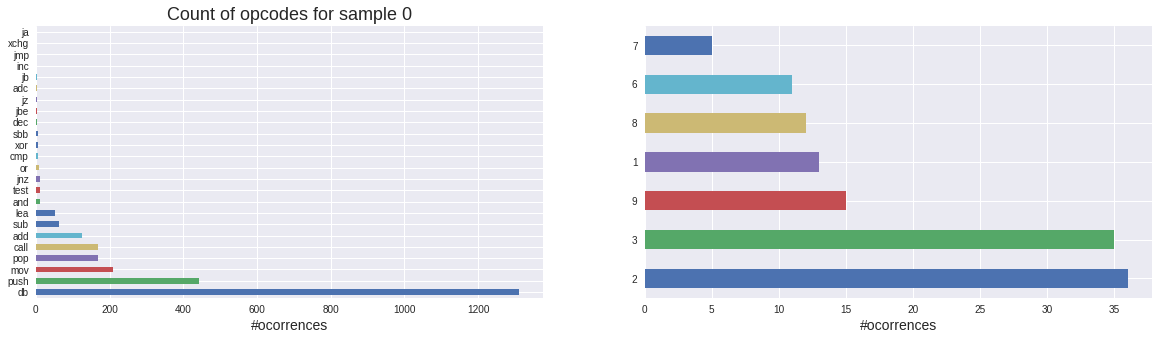

In [64]:
idx = 0

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_X.iloc[idx].value_counts().plot(kind = 'barh')
plt.title('Count of opcodes for sample {}'.format(idx), fontsize=18)
plt.xlabel('#ocorrences', fontsize=14)

plt.subplot(1,2,2)
df_y['targets'].value_counts().plot(kind = 'barh')
plt.xlabel('#ocorrences', fontsize=14)

## Split train and valid set

In [0]:
from sklearn.model_selection import train_test_split

In [66]:
test_size = 0.2
print('Test size: {}'.format(test_size))
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=42)

Test size: 0.2


In [67]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))

print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

X_train shape: (101,)
y_train shape: (101,)
X_valid shape: (26,)
y_valid shape: (26,)


## Saving processed data

In [0]:
def save_data(X, y, file, path2save):

    os.makedirs(path2save)
    
    data ={'X':X, 'y':y}
    np.savez(path2save + file + ".npz",**data)

    print('Saved in: {}'.format(path2save))  

In [69]:
path2saveTrain = 'proc_data/train/'
path2saveValid = 'proc_data/valid/'


if not os.path.exists(path2saveTrain):
    save_data(X_train, y_train,'opcodes', path2saveTrain)
    save_data(X_valid, y_valid,'opcodes', path2saveValid)

else:
    print('Data already processed!')

Saved in: proc_data/train/
Saved in: proc_data/valid/


# N-grams

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [71]:
max_gram = 4
print('Max_grams: {}'.format(max_gram))

Max_grams: 4


In [0]:
def get_n_grams(X, max_gram = 4):
  

    print('Counting ocorrences of words. Ngram-range: {}...'.format(str((1,max_gram))))
    
    vectorizer = CountVectorizer(analyzer = "word",
                                 max_features = 300,
                                 ngram_range=(1,max_gram)) 
    
    features = vectorizer.fit_transform([" ".join(x) for x in X])

    #downscale weights for words using tf–idf: “Term Frequency times Inverse Document Frequency”.
    print('Words downscaling using TF-IDF...')

    tfidf_transformer = TfidfTransformer()
    features = tfidf_transformer.fit_transform(features)
    
    features = features.toarray()
    model_vectorized = vectorizer
    model_tfidf = tfidf_transformer

    return model_vectorized, model_tfidf, features

In [82]:
model_vectorized, model_tfidf, f_train = get_n_grams(X_train)

Counting ocorrences of words. Ngram-range: (1, 4)...
Words downscaling using TF-IDF...


In [0]:
f_valid = model_vectorized.transform([" ".join(x) for x in X_valid])
f_valid = model_tfidf.transform(f_valid)
f_valid = f_valid.toarray()

In [97]:
print('Train features shape: {}'.format(f_train.shape))
print('Valid features shape: {}'.format(f_valid.shape))

Train features shape: (101, 300)
Valid features shape: (26, 300)


## Train classification model

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit( f_train, y_train )

In [0]:
result = forest.predict(f_valid)